In [1]:
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F   # All functions that don't have any parameters
from torch.utils.data import (DataLoader,)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torch.utils.data import Dataset
import pandas as pd
from skimage import io
import os
import numpy as np


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):

        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)



In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


In [4]:
def get_mean_std(loader):
    channel_sum, channel_squared_sum, num_batches = 0,0,0
    for data, _ in loader:
        channel_sum += torch.mean(data,dim= [ 0,2,3])
        channel_squared_sum = torch.mean(data**2,dim= [ 0,2,3])
        num_batches += 1

    mean = channel_sum/num_batches
    std = (channel_squared_sum/num_batches - mean**2)**0.5

    return  mean,std

In [5]:
    num_classes = 2
    learning_rate = 1e-3
    batch_size = 64
    num_epochs = 5
    my_transform = transforms.Compose([ transforms.ToPILImage(),
                                        transforms.Resize((224,224)),
                                       transforms.ToTensor()])


In [8]:
    path = os.getcwd()
    label_path = 'train_label.csv'
    data_path = '/home/saurabh/Desktop/Dataset/train'

    datasets = CatsAndDogsDataset(label_path,data_path,
                             transform= my_transform)
    train_set,test_set = torch.utils.data.random_split(datasets,[20000,4999])
    train_loader = DataLoader(dataset = train_set, batch_size = batch_size,shuffle= True)
    test_loader = DataLoader(dataset = test_set, batch_size = batch_size,shuffle= True)


In [9]:
#mean , std = get_mean_std(train_loader)
#print(mean, std)

In [10]:
def train(model,device,train_loader,criterion, optimizer,epoch):
    model.train()
    for i ,(data,targets) in enumerate(train_loader):
        data,targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%30 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(data), len(train_loader.dataset),
                                            100. * i / len(train_loader), loss.item()))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
                                                                                                    100. * correct / len(test_loader.dataset)))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet18(pretrained=True)
num_classes = 2
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
        nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, num_classes)
    )
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# after every 7 epoch we change our learning rate by factor 0.1
schedular = optim.lr_scheduler.StepLR(optimizer,step_size= 3, gamma = 0.1)

In [12]:
for epoch in range(num_epochs):
    train(model,device,train_loader,criterion,optimizer,epoch)
    schedular.step()
    test(model,device,test_loader)


Train Epoch: 0 [0/20000 (0%)]	Loss: 0.717723
Train Epoch: 0 [1920/20000 (10%)]	Loss: 0.139827
Train Epoch: 0 [3840/20000 (19%)]	Loss: 0.119778
Train Epoch: 0 [5760/20000 (29%)]	Loss: 0.155818
Train Epoch: 0 [7680/20000 (38%)]	Loss: 0.241362
Train Epoch: 0 [9600/20000 (48%)]	Loss: 0.283105
Train Epoch: 0 [11520/20000 (58%)]	Loss: 0.076602
Train Epoch: 0 [13440/20000 (67%)]	Loss: 0.134197
Train Epoch: 0 [15360/20000 (77%)]	Loss: 0.102776
Train Epoch: 0 [17280/20000 (86%)]	Loss: 0.268253
Train Epoch: 0 [19200/20000 (96%)]	Loss: 0.228430

Test set: Average loss: -3.3840, Accuracy: 4705/4999 (94%)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.025176
Train Epoch: 1 [1920/20000 (10%)]	Loss: 0.070004
Train Epoch: 1 [3840/20000 (19%)]	Loss: 0.056750
Train Epoch: 1 [5760/20000 (29%)]	Loss: 0.056103
Train Epoch: 1 [7680/20000 (38%)]	Loss: 0.067330
Train Epoch: 1 [9600/20000 (48%)]	Loss: 0.067726
Train Epoch: 1 [11520/20000 (58%)]	Loss: 0.056409
Train Epoch: 1 [13440/20000 (67%)]	Loss: 0.072373
Train Epo

In [13]:
model_name = 'dog_cat_model1.pth'
path = 'dataset' 

torch.save(model.state_dict(),model_name)

In [17]:
a = model
a.load_state_dict(torch.load(path))
a = a.cpu().double()


In [26]:
import matplotlib.pyplot as plt

image,labels = iter(test_loader).next()
img = image[34].reshape(224,224,3)
print(labels[1])


tensor(1)


It's a cat


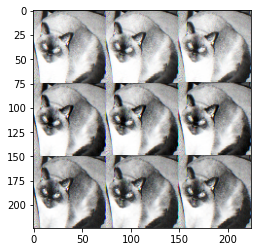

In [25]:
img = img.reshape(1,3,224,224)
#img = img.cuda()  # send an image to run on GPU if available
img = img.double() # model and varible must be same datatype
output = a(img)
if output[0][0] > output[0][1]:
    print('It\'s a cat')
#    output.append([i,0])
else:
    print('It\'s a dog')
 #   output.append([i, 1])
img = img.reshape(224,224,3)
plt.imshow(img)
plt.show()